# Download Dataset

## Import libraries

In [1]:
import os
import boto3
import logging
import pickle

from pathlib import Path

import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist as tf_dataset

## Load data

In [2]:
# set up logging
DEBUG_LEVEL = bool(int(os.getenv("DEBUG_LEVEL", 0)))

if DEBUG_LEVEL:
    logging.basicConfig(level=logging.DEBUG)
else:
    logging.basicConfig(level=logging.INFO)

_LOGGER = logging.getLogger(__name__)


def _is_file_downloaded(file_downloaded_path: Path) -> bool:
    """Check if file is already downloaded."""
    if os.path.exists(file_downloaded_path):
        _LOGGER.info(
            "{} already exists, skipping ...".format(file_downloaded_path)
        )
        return True

    return False


# Prepare MNIST data.
(x_train, y_train), (x_test, y_test) = tf_dataset.load_data()

8


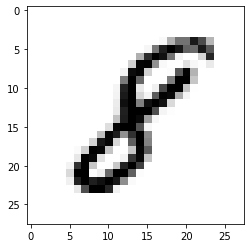

In [3]:
image_index = 7777  # You may select anything up to 60,000
print(y_train[image_index])  # The label is 8
plt.imshow(x_train[image_index], cmap="Greys")

## Store files

In [4]:
use_ceph = bool(int(os.getenv("USE_CEPH", 0)))
automation = bool(int(os.getenv("AUTOMATION", 0)))
project_name = os.environ.get("PROJECT_NAME", "elyra-aidevsecops-tutorial")

dataset = {
    "xdata.pkl": x_train,
    "ydata.pkl": y_train,
    "xtestdata.pkl": x_test,
    "ytestdata.pkl": y_test,
}

if automation:
    # Store file relative to directory
    destination_path = Path(str(os.environ.get("DATASET", "data/raw")))

else:

    # Set path where to store
    directory_path = Path.cwd().parents[0]
    destination_path = directory_path.joinpath(
        str(os.environ.get("DATASET", "data/raw"))
    )

    if use_ceph:

        s3_endpoint_url = os.environ["OBJECT_STORAGE_ENDPOINT_URL"]
        s3_access_key = os.environ["AWS_ACCESS_KEY_ID"]
        s3_secret_key = os.environ["AWS_SECRET_ACCESS_KEY"]
        s3_bucket = os.environ["OBJECT_STORAGE_BUCKET_NAME"]

        # Create an S3 client
        s3 = boto3.client(
            service_name="s3",
            aws_access_key_id=s3_access_key,
            aws_secret_access_key=s3_secret_key,
            endpoint_url=s3_endpoint_url,
        )


# Store MNIST data for next step.
for data_name, data_file in dataset.items():

    if not os.path.exists(destination_path):
        destination_path.mkdir(parents=True, exist_ok=True)

    file_downloaded_path = destination_path.joinpath(data_name)

    if use_ceph:
        key = f"{project_name}/data/raw/{data_name}"
        print(key)
        s3.upload_file(
            Bucket=s3_bucket, Key=key, Filename=str(file_downloaded_path)
        )

    else:

        if not _is_file_downloaded(file_downloaded_path):
            output = open(file_downloaded_path, "wb")
            pickle.dump(data_file, output)
            output.close()
            _LOGGER.info("Stored {}".format(file_downloaded_path))

INFO:__main__:/opt/app-root/src/nb-pr/elyra-aidevsecops-tutorial/data/raw/xdata.pkl already exists, skipping ...
INFO:__main__:/opt/app-root/src/nb-pr/elyra-aidevsecops-tutorial/data/raw/ydata.pkl already exists, skipping ...
INFO:__main__:/opt/app-root/src/nb-pr/elyra-aidevsecops-tutorial/data/raw/xtestdata.pkl already exists, skipping ...
INFO:__main__:/opt/app-root/src/nb-pr/elyra-aidevsecops-tutorial/data/raw/ytestdata.pkl already exists, skipping ...
